In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/needle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/needle


In [21]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [22]:
device = torch.device("cuda")
print(device)

cuda


#### **数据集 (CIFAR10Dataset)**

In [23]:
import urllib.request
import os

!mkdir -p './data/ptb'

# Download CIFAR-10 dataset
if not os.path.isdir("./data/cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./data/cifar-10-python.tar.gz")
    !tar -xvzf './data/cifar-10-python.tar.gz' -C './data'

## 定义DataSet

In [40]:
class CIFAR10Dataset(Dataset):
    def __init__(
        self,
        base_folder: str,
        train: bool,
    ):
        """
        Parameters:
        base_folder - cifar-10-batches-py folder filepath
        train - bool, if True load training dataset, else load test dataset
        Divide pixel values by 255. so that images are in 0-1 range.
        Attributes:
        X - numpy array of images
        y - numpy array of labels
        """
        import pickle
        import os
        if train:
            Xs = []
            ys = []
            for i in range(1, 6):
                with open(os.path.join(base_folder, f'data_batch_{i}'), 'rb') as f:
                    datas = pickle.load(f, encoding='bytes')
                    Xs.append(datas[b'data'])
                    ys += datas[b'labels']
            self.X = np.concatenate(Xs, axis=0).reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1)) / 255.
            self.y = np.array(ys, dtype=np.uint8)
        else:
            with open(os.path.join(base_folder, 'test_batch'), 'rb') as f:
                datas = pickle.load(f, encoding='bytes')
            self.X = datas[b'data'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1)) / 255.
            self.y = np.array(datas[b'labels'], dtype=np.uint8)


    def __getitem__(self, index):
        """
        Returns the image, label at given index
        Image should be of shape (3, 32, 32)
        """
        imgs = self.X[index]
        if len(imgs.shape) == 4:
            return imgs.transpose((0, 3, 1, 2)).astype(np.float32), self.y[index]
        else:
            return imgs.transpose((2, 0, 1)).astype(np.float32), self.y[index]


    def __len__(self) -> int:
        """
        Returns the total number of examples in the dataset
        """
        return self.y.shape[0]

#### **定义 DataLoader**

In [41]:
batch_size = 128

train_dataset = CIFAR10Dataset("data/cifar-10-batches-py", train=True)
test_dataset = CIFAR10Dataset("data/cifar-10-batches-py", train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 使用needle定义模型

In [52]:
class ConvBN(nn.Module):
    def __init__(self, a, b, k, s, p=1) -> None:
        super().__init__()
        self.a = a
        self.b = b
        self.k = k
        self.s = s

        self.conv2d = nn.Conv2d(a, b, kernel_size=k, stride=s, padding=p)
        self.batch_norm = nn.BatchNorm2d(b)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv2d(x)
        x = self.batch_norm(x)
        return self.relu(x)


## currently not implement pooling
## replace pooling with striding
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            ConvBN(3, 64, 7, 4),
            ConvBN(64, 128, 3, 2),
        )
        self.layer2 = nn.Sequential(
            ConvBN(128, 128, 3, 1),
            ConvBN(128, 128, 3, 1),
        )
        self.layer3 = nn.Sequential(
            ConvBN(128, 256, 3, 2),
            ConvBN(256, 512, 3, 2),
        )
        self.layer4 = nn.Sequential(
            ConvBN(512, 512, 3, 1),
            ConvBN(512, 512, 3, 1),
        )
        self.linear1 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x) + x
        x = self.layer3(x)
        x = self.layer4(x) + x
        x = nn.Flatten()(x)
        x = self.linear1(x)
        return x

## 训练和测试

### 超参数设置

In [53]:
num_classes = 10
num_epochs = 10
learning_rate = 1e-4

model = ResNet18(num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

### 模型训练


In [55]:
import gc

train_loss_lst = []

model.train()
for epoch in range(num_epochs):
    with tqdm(train_loader, desc='Train [{}/{}]'.format(epoch+1, num_epochs), mininterval=1.0) as t:
        for batch in t:
            images, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_lst.append(loss.item())
            t.set_postfix(loss=loss.item())
            del images, labels, outputs
            gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, loss.item()))

Train [1/10]: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s, loss=1.48]


Epoch [1/10], Loss: 1.4846


Train [2/10]: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s, loss=1.26]


Epoch [2/10], Loss: 1.2560


Train [3/10]: 100%|██████████| 391/391 [01:04<00:00,  6.02it/s, loss=1.04]


Epoch [3/10], Loss: 1.0415


Train [4/10]: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s, loss=0.849]


Epoch [4/10], Loss: 0.8488


Train [5/10]: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s, loss=0.722]


Epoch [5/10], Loss: 0.7222


Train [6/10]: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s, loss=0.331]


Epoch [6/10], Loss: 0.3314


Train [7/10]: 100%|██████████| 391/391 [01:04<00:00,  6.02it/s, loss=0.204]


Epoch [7/10], Loss: 0.2040


Train [8/10]: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s, loss=0.166]


Epoch [8/10], Loss: 0.1658


Train [9/10]: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s, loss=0.114]


Epoch [9/10], Loss: 0.1141


Train [10/10]: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, loss=0.227]

Epoch [10/10], Loss: 0.2267


### 训练损失曲线可视化


In [56]:
import matplotlib.pyplot as plt


def learning_curve(train_loss_lst, num_epochs, _ylabel1='train loss', smooth_factor=10):
    """
    Args:
        smooth_factor: 平滑因子，只能取正整数。平滑因子越大，损失曲线越平滑
    """

    assert smooth_factor > 0 and type(smooth_factor) == int

    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel(_ylabel1, color=color)
    train_loss_x = list(range(len(train_loss_lst)))
    ax1.plot(train_loss_x[::smooth_factor], train_loss_lst[::smooth_factor], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()


========================= LEARNING CURVE =======================


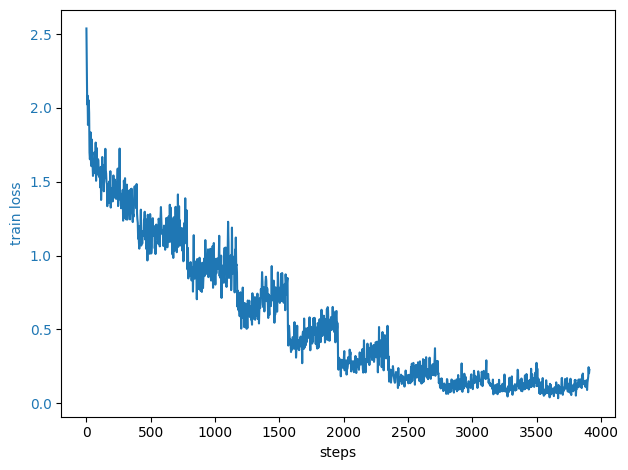

In [57]:
print('========================= LEARNING CURVE =======================')
learning_curve(train_loss_lst, num_epochs, smooth_factor=3)

### 模型测试

In [61]:
model.eval()
correct = 0
total = 0
for images, labels in tqdm(train_loader, desc='Test', mininterval=1.0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    pred = np.argmax(outputs.cpu().detach().numpy(), axis=1)

    total += labels.shape[0]
    correct += (pred == labels.cpu().detach().numpy()).sum().item()
    del images, labels, outputs

print('Accuracy of the network on the {} train images: {:.4f} %'.format(len(train_dataset), 100 * correct / total))

Test: 100%|██████████| 391/391 [00:01<00:00, 214.38it/s]

Accuracy of the network on the 50000 train images: 94.4500 %


In [63]:
model.eval()
correct = 0
total = 0
for images, labels in tqdm(test_loader, desc='Test', mininterval=1.0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    pred = np.argmax(outputs.cpu().detach().numpy(), axis=1)

    total += labels.shape[0]
    correct += (pred == labels.cpu().detach().numpy()).sum().item()
    del images, labels, outputs

print('Accuracy of the network on the {} test images: {:.4f} %'.format(len(test_dataset), 100 * correct / total))

Test: 100%|██████████| 79/79 [00:00<00:00, 129.55it/s]

Accuracy of the network on the 10000 test images: 52.9300 %
